##Problem 1 - CIFAR-100 Classification
Please change the Edit>Notebook>Hardware Accelerator settings in Colab from None to GPU.

In [ ]:
# Check the GPU information
!nvidia-smi

Wed Apr 26 03:23:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# CIFAR-100 classification
import torch
import torchvision
from torchvision import transforms

# Define the batch size
batch_size = 4
# Define the transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training set
train_set = torchvision.datasets.CIFAR10(root ='./data', train = True, download = True, transform = transform)
# Load the test set
test_set = torchvision.datasets.CIFAR10(root ='./data', train = False, download = True, transform = transform)

# Create data loaders to load the data in batches
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

100%|██████████| 170498071/170498071 [00:01<00:00, 98592467.04it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define the model
from torchvision.models import resnet18, ResNet18_Weights

# Use pretrained weights
net = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [ ]:
# Define the loss and the optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min = 0, last_epoch =- 1, verbose = False)

In [ ]:
# Train the network
acc_list = []
for epoch in range(epochs):  # Loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()
            
    # Test the network
    net.eval()
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # Calculate outputs by running images through the network
            outputs = net(images)            
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc_list.append(100 * correct // total)

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Streaming output truncated to the last 5000 lines.
[17,    51] loss: 0.006
[17,    61] loss: 0.007
[17,    71] loss: 0.009
[17,    81] loss: 0.007
[17,    91] loss: 0.008
[17,   101] loss: 0.008
[17,   111] loss: 0.007
[17,   121] loss: 0.007
[17,   131] loss: 0.007
[17,   141] loss: 0.009
[17,   151] loss: 0.007
[17,   161] loss: 0.008
[17,   171] loss: 0.008
[17,   181] loss: 0.010
[17,   191] loss: 0.007
[17,   201] loss: 0.008
[17,   211] loss: 0.007
[17,   221] loss: 0.008
[17,   231] loss: 0.008
[17,   241] loss: 0.009
[17,   251] loss: 0.008
[17,   261] loss: 0.007
[17,   271] loss: 0.007
[17,   281] loss: 0.008
[17,   291] loss: 0.008
[17,   301] loss: 0.008
[17,   311] loss: 0.008
[17,   321] loss: 0.008
[17,   331] loss: 0.008
[17,   341] loss: 0.008
[17,   351] loss: 0.007
[17,   361] loss: 0.007
[17,   371] loss: 0.008
[17,   381] loss: 0.008
[17,   391] loss: 0.008
[17,   401] loss: 0.008
[17,   411] loss: 0.007
[17,   421] loss: 0.009
[17,   431] loss: 0.008
[17,   441] l

##Problem 2 - Flowers102 Classification
Note: for the last step, plot the testing accuracy curve across the epochs. To do this, remember to store all the accuracy numbers in a Python list during the training.

In [ ]:
from posixpath import split
# Flowers102 classification
import torch
import torchvision
from torchvision import transforms

# Define the batch size
batch_size = 256

# Define the transform to normalize the data
# Resize to 224x224 (height x width)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the image to 224x224
    transforms.ToTensor(),  # convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training set
train_set = torchvision.datasets.Flowers102(root='./data', split = 'train',
                    download=True, transform=transform)

# Load the test set
test_set = torchvision.datasets.Flowers102(root='./data', split = 'test',
                    download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                      shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                     shuffle=False, num_workers=2)

100%|██████████| 344862509/344862509 [00:01<00:00, 204458034.99it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 673772.99it/s]


100%|██████████| 14989/14989 [00:00<00:00, 19208195.13it/s]


In [ ]:
# Define the model
from torchvision.models import resnet18, ResNet18_Weights

# Using pretrained weights:
net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [ ]:
# Define the loss and the optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min = 0, last_epoch =- 1, verbose = False)

In [ ]:
# Train the network
acc_list = []

for epoch in range(epochs):  # Loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()
            
    # Test the network
    net.eval()
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # Calculate outputs by running images through the network
            outputs = net(images)            
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        acc_list.append(100 * correct // total)

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,     1] loss: 0.005
Accuracy of the network on the 10000 test images: 0 %
[2,     1] loss: 0.004
Accuracy of the network on the 10000 test images: 10 %
[3,     1] loss: 0.002
Accuracy of the network on the 10000 test images: 24 %
[4,     1] loss: 0.001
Accuracy of the network on the 10000 test images: 33 %
[5,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 44 %
[6,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 52 %
[7,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 57 %
[8,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 60 %
[9,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 61 %
[10,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 62 %
[11,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 62 %
[12,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 63 %
[13,     1] loss: 0.000
Accuracy of the network on the 10000 t

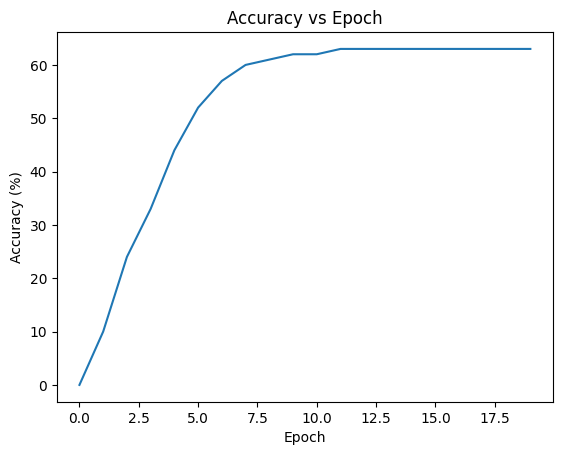

In [ ]:
# Plot the testing accuracy curve across the epochs
# Remember to store all the accuracy numbers in a Python list during the training.
import matplotlib.pyplot as plt

plt.plot(range(epochs), acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.show()